# GA Data Science SF 14 (DAT14)

### Logistic Regression

thanks to [Olivier Grisel](https://github.com/ogrisel/parallel_ml_tutorial)


## Example: Logistic Regression On Titanic Dataset

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
titanic_file = '../homework/hw1/titanic.csv'
data = pd.read_csv(titanic_file)

In [4]:
data.Survived.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

Question: what is our prediction benchmark for model?

In [6]:
print data.Survived.mean()
print 1 - data.Survived.mean()

0.383838383838
0.616161616162


From this the subset of the full passengers list, about 2/3 perished in the event. So if we are to build a predictive model from this data, a baseline model to compare the performance to would be to always predict death. Such a constant model would reach around 62% predictive accuracy (which is higher than predicting at random):

In [7]:
target = data.Survived.values

`sklearn` estimators all work with homegeneous numerical feature descriptors passed as a numpy array. Therefore passing the raw data frame will not work out of the box.

Let us start simple and build a first model that only uses readily available numerical features as input, namely `data.Fare`, `data.Pclass` and `data.Age`.

In [8]:
numerical_features = data.get(['Fare', 'Pclass', 'Age'])
numerical_features.head(5)

,Fare,Pclass,Age
0,7.2500,3,22
1,71.2833,1,38
2,7.9250,3,26
3,53.1000,1,35
4,8.0500,3,35


Unfortunately some passengers do not have age information:

In [9]:
numerical_features.count()

Fare      891
Pclass    891
Age       714
dtype: int64

Let's use pandas `fillna` method to input the median age for those passengers:

In [10]:
median_features = numerical_features.dropna().median()
median_features

Fare      15.7417
Pclass     2.0000
Age       28.0000
dtype: float64

In [11]:
imputed_features = numerical_features.fillna(median_features)
imputed_features.count()

Fare      891
Pclass    891
Age       891
dtype: int64

In [12]:
imputed_features.head(5)

,Fare,Pclass,Age
0,7.2500,3,22
1,71.2833,1,38
2,7.9250,3,26
3,53.1000,1,35
4,8.0500,3,35


Now that the data frame is clean, we can convert it into an homogeneous numpy array of floating point values:

In [13]:
features_array = imputed_features.values
features_array

array([[  7.25  ,   3.    ,  22.    ],
       [ 71.2833,   1.    ,  38.    ],
       [  7.925 ,   3.    ,  26.    ],
       ..., 
       [ 23.45  ,   3.    ,  28.    ],
       [ 30.    ,   1.    ,  26.    ],
       [  7.75  ,   3.    ,  32.    ]])

Let's take the 80% of the data for training a first model and keep 20% for computing is generalization score:

In [14]:
from sklearn.cross_validation import train_test_split

features_train, features_test, target_train, target_test = train_test_split(
    features_array, target, test_size=0.20, random_state=0)

In [15]:
features_train.shape

(712, 3)

In [16]:
features_test.shape

(179, 3)

In [17]:
target_train.shape

(712,)

In [18]:
target_test.shape

(179,)

Let's start with a simple model from sklearn, namely `LogisticRegression`:

In [19]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(features_train, target_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

In [20]:
target_predicted = lr.predict(features_test)

In [21]:
from sklearn.metrics import accuracy_score

accuracy_score(target_test, target_predicted)

0.73184357541899436

In [22]:
### exercise: write your own function to calculate the accuracy score:



This first model has around 73% accuracy: this is better than our baselines that always predicts death.

## Model evaluation and interpretation

### Interpreting linear model weights

The `coef_` attribute of a fitted linear model such as `LogisticRegression` holds the weights of each features:

In [23]:
feature_names = numerical_features.columns.values
feature_names

array(['Fare', 'Pclass', 'Age'], dtype=object)

In [24]:
lr.coef_

array([[ 0.0043996 , -0.80916725, -0.03348064]])

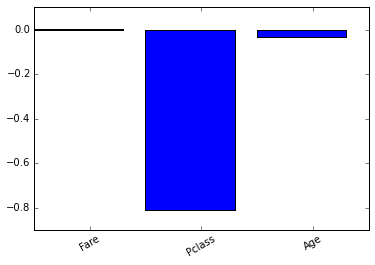

In [25]:
x = np.arange(len(feature_names))
plt.bar(x, lr.coef_.ravel())
_ = plt.xticks(x + 0.5, feature_names, rotation=30)

In this case, survival is slightly positively linked with Fare (the higher the fare, the higher the likelyhood the model will predict survival) while passenger from first class and lower ages are predicted to survive more often than older people from the 3rd class.

First-class cabins where closer to the lifeboats and children and women reportedly had the priority. Our model seems to capture that historical data. We will see later if the sex of the passenger can be used as an informative predictor to increase the predictive accuracy of the model.

### Predicting the Probability of Being in Class 1

Logistic Regression is a probabilistic models: instead of just predicting a binary outcome (survived or not) given the input features it can also estimates the posterior probability of the outcome given the input features using the `predict_proba` method:

In [26]:
target_predicted_proba = lr.predict_proba(features_test)
target_predicted_proba[:5]

array([[ 0.75263264,  0.24736736],
       [ 0.75824771,  0.24175229],
       [ 0.58542437,  0.41457563],
       [ 0.25224882,  0.74775118],
       [ 0.75817844,  0.24182156]])

By default the decision threshold is 0.5: if we vary the decision threshold from 0 to 1 we could generate a family of binary classifier models that address all the possible trade offs between false positive and false negative prediction errors.

In [27]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(target_test, target_predicted))

[[98 12]
 [36 33]]


Another way to quantify the quality of a binary classifier on imbalanced data is to compute the precision, recall and f1-score of a model (at the default fixed decision threshold of 0.5).

In [28]:
from sklearn.metrics import classification_report

print(classification_report(target_test, target_predicted,
                            target_names=['not survived', 'survived']))

              precision    recall  f1-score   support

not survived       0.73      0.89      0.80       110
    survived       0.73      0.48      0.58        69

 avg / total       0.73      0.73      0.72       179



From the [Docs](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html):

```python
class sklearn.linear_model.LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None)¶
```


| Attributes
|:-----------|:----------|:----------|
| coef_ | array, shape = [n_classes-1, n_features]| Coefficient of the features in the decision function. coef_ is readonly property derived from raw_coef_ that follows the internal memory layout of liblinear.|
| intercept_  |array, shape = [n_classes-1] | Intercept (a.k.a. bias) added to the decision function. It is available only when parameter intercept is set to True.|
| random_state: int seed, RandomState instance, or None (default) | |The seed of the pseudo random number generator to use when shuffling the data.|



| Methods
|:-----------|:----------|
| decision_function(X) | Predict confidence scores for samples.|
| densify() |Convert coefficient matrix to dense array format.|
| fit(X, y) |Fit the model according to the given training data.|
| fit_transform(X[, y]) |Fit to data, then transform it.|
| get_params([deep]) | Get parameters for this estimator.|
| predict(X)  | Predict class labels for samples in X.|
| predict_log_proba(X) | Log of probability estimates.|
| predict_proba(X) | Probability estimates.|
| score(X, y) |  Returns the mean accuracy on the given test data and labels.|
| set_params(\*\*params) | Set the parameters of this estimator.|
| sparsify() | Convert coefficient matrix to sparse format.|
| transform(X[, threshold]) |Reduce X to its most important features.|

In [ ]:
### exercise: change 


# Short Version: Logistic Regression on Titanic Dataset

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


# import data
data = pd.read_csv('titanic-train.csv')
#fill na, define features and target numpy arrays
numerical_features = data.get(['Fare', 'Pclass', 'Age'])
features_array = numerical_features.fillna(numerical_features.dropna().median()).values
target = data.Survived.values

# train test split
features_train, features_test, target_train, target_test = train_test_split(features_array, target, test_size=0.20, random_state=0)


# train logistic regression, evaluate on test
lr = LogisticRegression(C=1)
lr.fit(features_train, target_train)
target_predicted = lr.predict(features_test)

print(target_test)
print(target_predicted)

#evaluate accuracy
#print("\n\nLogistic regression of Titanic Dataset on Numerical Features\n\n")

#print(classification_report(target_test, target_predicted,
#                            target_names=['not survived', 'survived']))

[0 0 0 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 1 0 1 0 1 0
 0 0 0 1 0 0 0 1 0 0 1 0 0 1 1 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 1 1 1 1 0 0
 0 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0
 1 1 0 1 1 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1
 1 0 0 1 0 0 1 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0]
[0 0 0 1 0 1 1 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0
 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0
 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0]
